# SDA: Assignment 3

**Name**:

**Student ID**:

# Introduction

In the previous two assignments you have focused on cross-sectional data where the values in each data sample are i.i.d. and have no particular ordering. In this assignment we will study time-series where the values in each data sample have a specific ordering. We will start in Problem 1 still in a cross-sectional but paired samples setting, which in the subsequent problems is applied to studying real time-series.
In this assignment you will learn:
1. The concept of statistical dependence between two variables;
2.  Linear Regression Model;
3.  A general fitting procedure for model parameters;
4. The concept of correlation and of variance explained; 
5. Generating your own time-series;
6. The concept of order of integration and co-integration; 
7. The pitfall of and solution to spurious correlation.

## Coding and References
You should use the Python programming language for all programming tasks. You should use native Python code for all tasks unless otherwise instructed. Whenever you have already implemented a particular function before by yourself, from that point onward you are allowed to use the more efficient implementation from a package. So for instance, if you have already implemented yourself the `mean()` function and have used it at least once in an answer then you are allowed to use the `np.mean()` function from numpy.

The exceptions are:
1. the logarithm function, which you may find in the packages `math` or `numpy`.
2. the square root function √x, which can be computed using `x**0.5`.
Further Exception (only week 4): the use of vectors and matrices (`numpy.array`) is additionally allowed in week 4's assignment. (Essentially I assume that you know how to implement multidimensional arrays by nesting lists, so no need to show that explicitly.) Still, before you use the `np.dot` (dot product) function from numpy, for instance, implement it yourself first to show that you know what it does exactly. Also for clustering, such as k-means clustering: implement it yourself first and use it at least once to show that it works. If needed for performance reasons you can subsequently use the implementation from the `sklearn` package, for example.  

For some questions you may have to look up certain facts, formulas, equations, or freshen up your knowledge. The problems in the assignments do not always refer to pertinent sources; you are expected to research into missing knowledge yourself. 
For refreshers of the very basics of probability theory, or additional resources behind statistical concepts introduced here, please look on Canvas for the resources provided.

Please do not ever copy (parts of) your answer or code from any other source, be it online or from fellow students. You can help each other understand the problem and to compare outcomes, but not copy answers.

## Submission
Please upload your answers to all questions in Jupyter Notebook format (.ipynb extension) through the appropriate Canvas page no later than Sunday, November 17th, 2024 at 23:59. Your answers and derivations should be included inline in your Jupyter Notebook file (do not remove any output before saving the file). Be sure to make every step explicit and clearly identifiable (computational performance or code brevity are not graded). Submissions by e-mail or past this deadline will not be considered.
Deadline extension requests will not be considered unless they are mediated through a study advisor.

## Grading
You can earn a maximum of 112 points. In case you do not submit both your answers and code by the deadline then you receive an “NA”. If you submit your answers and code but score 0 points then your grade will be a 1 (Dutch grading system). Scoring all 112 points means your grade becomes a 10. An amount of bonus points can be earned which is added to your score to a maximum of 112. That is, each week you can earn a maximum grade of 10 and it is not possible to transfer (bonus) points from one assignment to another.

Each of the weekly assignments will have a relative weight proportional to the maximum number of points. In total they make up 50% of your final grade.

**LINK TO PRELIMINARY MATERIAL FOR THE COURSE** https://www.overleaf.com/read/tygcjfmjjpss
 Here you can find a pdf, which is continuous update, to download.

In [181]:
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

# YOUR OTHER IMPORTS HERE

seed = 69

def randint(a=1664525, c=1013904223, m=2**32):
    global seed
    seed = (a * seed + c) % m
    return seed

def rand():
    return randint() / 2**32

def randnorm(mu, sigma):
    return mu + sigma*(2**0.5)*erfinv(2*rand()-1)

def randlognorm(mu, sigma):
    return np.exp(randnorm(mu, sigma))

def mean(data):
    return sum(data)/len(data)

def std(data):
    m = mean(data)
    return (sum([(x-m)**2 for x in data])/len(data))**0.5

def percentile(values, alpha):
    values.sort()
    length = alpha * (len(values) -1)
    lower = int(length)
    # Lower value ios not a int most of the time so we need to interpolate
    upper = lower + 1

    if upper > len(values) - 1:
        return values[-1]
    
    lower_val = values[lower]
    upper_val = values[upper]

    # linear interpolation between the two points
    return lower_val + ((upper_val - lower_val)/ (upper - lower)) * (length - lower)

## Problem 1

In this problem you start in a cross-sectional but paired samples setting, which in the subsequent problems
is applied to studying real time-series. Remember, capital letters stand for stochastic variables, lower-case
letters stand for a specific value, and a vector like $\vec{s}$ denotes a data sample containing multiple values (whose
ordering will start to matter in this assignment as we deal with time series).

Let us consider a data sample of paired observations $\overrightarrow{S}_n = (X_1, Y_1), \dots, (X_n, Y_n)$. For $Y_i$ let us consider the statistical model

\begin{align*}
    Y_i \sim \mathcal{N}(\mu_i, \sigma^2_{Y\mid X})\quad\quad\quad\quad\text{(1)}
\end{align*}

That is, each $Y_i$ follows a normal distribution with exactly the same variance $\sigma^2_{Y\mid X}$ but with a different mean.
The reason for the notation of $\sigma^2_{Y\mid X}$ will become clear during the problems. During this entire assignment we
will only deal with the *linear regression* model which is the simplest possible model to capture dependencies
between paired values, i.e.,

\begin{align*}
    \mu_i = \alpha + \beta \cdot X_i\quad\quad\quad\quad\quad\text{(2)}
\end{align*}

In this model, $\alpha$ is also called the *intercept* and $\beta$ is also called the *slope*.
For completeness, since Eq. 1 and Eq. 2 define the conditional probability $Pr (Y_i \mid X_i )$, all we need in order
to have a complete statistical description $Pr(X_i , Y_i )$ of each sample is the marginal probability distribution
$Pr(X_i )$. A typical distribution in the cross-sectional case is a normal distribution. A typical and simple distribution in the time-series case is $X_i \sim \mathcal{N}(i, \sigma^2_X)$, where $\sigma_X$ is small or even $\sigma_X \rightarrow 0$ i.e., $X_1,\dots,X_n$ denotes a regular interval (time stamps?) with possibly some variation. 

In this first problem we will consider the cross-sectional case with a normal distribution, so $X_i \sim \mathcal{N}(\mu_X, \sigma^2_X)$ (so the mean does not depend on time yet).

### 1.1
Write a function `randpair(mu_x, sigma_x, alpha, beta, sigma_y_x)` which will generate a
random pair $(x_i , y_i )$ and returns it as a tuple of length 2. For computational efficiency you may also
use the `np.random.normal` instead of your own implementation.

[4 points]

In [156]:
def randpair(mu_x, sigma_x, alpha, beta, sigma_y_x):
    x = np.random.normal(mu_x, sigma_x)
    y = np.random.normal(alpha + beta*x, sigma_y_x)
    return x, y

### 1.2 
Generate a data sample of $n = 10^3$ paired values which we will name $\vec s$ . As parameter values use:
$\mu_X = 0, \sigma_X = 1, \alpha = 0, \beta = 4.5, \sigma_{Y\mid X}  = 1.50$.

Show a scatter plot of this data sample such that
the $x_i$ value is on the x-axis and the $y_i$ value is on the y-axis. For evident reasons such plots are also
colloquially referred to as ‘cigar plots’. Overlay the corresponding line which describes the theoretically
expected value of $Y$ as function of $X$.

[4 points]

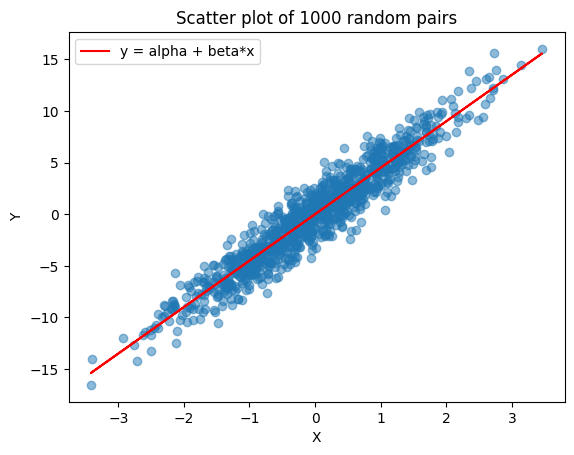

In [157]:
# YOUR CODE HERE
mu_x = 0
sigma_x = 1
alpha = 0
beta = 4.5
sigma_y_x = 1.5

s = [randpair(mu_x, sigma_x, alpha, beta, sigma_y_x) for _ in range(10**3)]

x = np.array([i[0] for i in s])
y = alpha + beta*x
plt.plot(x, y, color='red', label='y = alpha + beta*x')
plt.scatter([i[0] for i in s], [i[1] for i in s], alpha=0.5)
plt.title('Scatter plot of 1000 random pairs')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


### 1.3
Now let us pretend that we received this data sample $\vec s$ and do not know its generating model. Just as in the previous assignments there will be a *maximum likelihood estimate* for the intercept $\hat \alpha$, the slope
$\hat \beta$, and the noise level $\hat \sigma_{Y \mid X}$, but also a confidence interval for each of them. This will be important in the subsequent problems.

Your task will be to find the three parameters which maximize the conditional probability of the data sample to $\text{Pr}(\vec S\mid \hat \alpha, \hat \beta, \hat \sigma_{Y \mid X}) = \text{Pr}(\vec X, \vec Y\mid \hat \alpha, \hat \beta, \hat \sigma_{Y \mid X})$, which will be spit over multiple questions.

It is important to realize that the choice of the linear regression model (intercept, slope, noise level) has nothing to do with the marginal probabilities of the $x_i$ values, so $\text{Pr}(X_i\mid  \alpha,  \beta,  \sigma_{Y \mid X}) = P(X_i)$. Therefore, to start, use standard probability theory<sup>1</sup> to derive step by step the fact that the *optimization problem* reduces to maximizing the log-likelihood $\log L( \vec Y\mid \vec X,\hat \alpha, \hat \beta, \hat \sigma_{Y \mid X})$, where the probabilities of the $x_i$ no longer appear on the left of the vertical bar.


<span style="font-family:Arial; font-size: 0.8em;">Note 1: In particular, use the generalization of the rule $Pr(A, B) = Pr(A | B) Pr(B)$ which is: $Pr(A, B | C) = Pr(A | B, C) Pr(B | C)$.
The symbols $A, B, C$ may either constitute a single stochastic variable or a combination (intersection) of stochastic variables.</span>

[6 points]

By using the standard rule $Pr(A, B) = Pr(A | B) Pr(B)$ which is: $Pr(A, B | C) = Pr(A | B, C) Pr(B | C)$ on $\text{Pr}(\vec X, \vec Y\mid \hat \alpha, \hat \beta, \hat \sigma_{Y \mid X})$ we get $\text{Pr}(\vec Y\mid \vec X, \hat \alpha, \hat \beta, \hat \sigma_{Y \mid X}) \text{Pr}(\vec X \mid \hat \alpha, \hat \beta, \hat \sigma_{Y \mid X})$

As said above  $\text{Pr}(X_i\mid  \alpha,  \beta,  \sigma_{Y \mid X}) = P(X_i)$ sp it becomes $\text{Pr}(\vec Y\mid \vec X, \hat \alpha, \hat \beta, \hat \sigma_{Y \mid X}) \text{Pr}(X_i)$

The next step is to re write it $\frac{\text{Pr}(\vec X, \vec Y\mid \hat \alpha, \hat \beta, \hat \sigma_{Y \mid X})}{\text{Pr}(X_i)} = \text{Pr}(\vec Y\mid \vec X, \hat \alpha, \hat \beta, \hat \sigma_{Y \mid X})$ Since it has nothing to do with the marginal probabilities we can say that maximizing $\text{Pr}(\vec Y\mid \vec X, \hat \alpha, \hat \beta, \hat \sigma_{Y \mid X})$ means maximzing $\text{Pr}(\vec X, \vec Y\mid \hat \alpha, \hat \beta, \hat \sigma_{Y \mid X})$ so we can say $\log L( \vec Y\mid \vec X,\hat \alpha, \hat \beta, \hat \sigma_{Y \mid X})$

### 1.4
There is a crucial assumption that you will need to make regarding this cross-sectional sample $\vec s$ , which
was also made in Assignment 1. Name this assumption and write the new formula for the log-likelihood
that this assumption enables, which is needed for being able to calculate the log-likelihood.

[4 points]

The assumption here is that we can treat $X_i$ and $Y_i$ as independent from each other

Formula = $$\log L( \vec Y\mid \vec X,\hat \alpha, \hat \beta, \hat \sigma_{Y \mid X}) = \sum_{i=1}^n \log \text{Pr}(\vec Y_i\mid \vec X_i,\hat \alpha, \hat \beta, \hat \sigma_{Y \mid X})$$

### 1.5
Now you are ready to implement `loglikelihood_lrm(alpha, beta, sigma_y, sample)` which
will compute the log-likelihood of the given list of paired values (i.e., `sample`) given the linear regression model defined by the parameters $\alpha, \beta, \sigma_{Y\mid X}$ . For inspiration you may want to look back at your Assignment 1.

For computational speed, the probability density of value $x$ given a normal distribution $\mathcal{N}(\mu, \sigma)$
may also be calculated using `st.norm.pdf(x, loc=mu, scale=sigma)`. You may test your implementation using your answer for question 2; the
correct parameter values should yield a higher likelihood than other parameter values (such a setting
the slope to zero).

[8 points]

In [158]:
def loglikelihood_lrm(alpha, beta, sigma_y, sample):
    return sum([st.norm.logpdf(y, loc=alpha+beta*x, scale=sigma_y) for x, y in sample])
print(loglikelihood_lrm(alpha, beta, sigma_y_x, s))

-1829.3988891222066


### 1.6

Although there is a simple analytical way to estimate the parameters for the linear regression, in general
there is not, so you will now implement a general procedure. Implement a function `fit_lrm(sample)` which takes a list of 2-tuples as input and returns a tuple $(\hat \alpha, \hat \beta, \hat \sigma_{Y \mid X})$ with the estimated MLE values
for the intercept, slope, and noise level of a linear regression model (LRM). Finding the parameter
values which maximize a function is called an optimization procedure. You are free regarding the
optimization technique you use, as long as it is implemented by yourself. Simple possibilities include:

* Generating many random parameter values within certain ranges and remembering the parameter set which maximizes the log-likelihood;
* A nested for-loop, one for each parameter, with a constant step size for each parameter value within a certain range, so that a regular grid of parameter values is considered;
* (Bonus +2) A nested version of one of the previous options: first a large range of values is considered, and then in each subsequent iteration a smaller range of parameter values is considered around the best solution of the previous iteration (2 or 3 iterations may be practically sufficient)
* (Bonus +2) Greedy gradient ascent: select a random parameter set, compute the log-likelihood, then generate a random vector with small norm (small individual values) which is added to this parameter set, compute the log-likelihood of this new parameter set: if it is higher, take the new parameter set as your ‘current’ set, otherwise keep your current set as it is. Stop the search when a sufficient number of times your parameter set did not improve.

Again, you may want to test your implementation using the sample you have already generated and
the corresponding known parameter values which this function should reproduce approximately.

**Warning :** If you use a package implementation of the gaussian pdf, beware of the same problem you have already encountered in assignment 1 when computing the log of a too low value for the pdf. 

$log (e^{-100000})$ should be equal to -100000 but your machine will approximate $e^{-100000}$ as $0$ and so you may want to implement the simplification with the logarithm directly in your code.

**'Cutting Corners'.** To narrow your search range and thus speed up the optimization procedure you
may adjust the ranges in which you search. For instance, depending on how the scatter plot looks you may decide that the slope can never be negative. Excluding such options may greatly reduce the time it
takes for your optimization to complete<sup>2</sup>. You may also extend the argument list of your optimization
function with the ranges in which the search should take place, if you wish.

<span style="font-family:Arial; font-size: 0.8em;">Note 2: The second option takes about one minute to complete on my laptop for the case of 10 × 10 × 10 parameter sets. So
100 × 100 × 100, which is better, would take about 1000 minutes or about 16 hours.</span>

**Failsafe.** In case you do not (yet) manage to implement your own optimization procedure you may use the following implementation of the function. Naturally, using this implementation will not earn you any points for this question; in all subsequent questions you can then still earn full points. Nevertheless, in subsequent questions and problems you will be allowed to use this provided implementation instead of your own implementation for the sake of accuracy and speed, unless explicitly stated. 

```python
from scipy.optimize import minimize



def failsafe_fit_lrm(sample):
    optres = minimize(lambda tup: -loglikelihood_lrm(*tup, sample=sample),
                     (0, 0, 1),
                     bounds=((None, None), (None, None), (0.001, None)))
    return optres.x
```

[6 points] 

[2 bonus points]

In [159]:
def fit_lrm(sample):
    alpha_range = np.linspace(0.0, 10.0, 10)
    beta_range = np.linspace(0, 10.0, 10)
    sigma_y_range = np.linspace(0.75, 10.0, 10)
    best_loglikelihood = -np.inf
    best_alpha = 0
    best_beta = 0
    best_sigma_y = 0

    for alpha in alpha_range:
        for beta in beta_range:
            for sigma_y in sigma_y_range:
                if loglikelihood_lrm(alpha, beta, sigma_y, sample) > best_loglikelihood:
                    best_loglikelihood = loglikelihood_lrm(alpha, beta, sigma_y, sample)
                    best_alpha = alpha
                    best_beta = beta
                    best_sigma_y = sigma_y
    return best_alpha, best_beta, best_sigma_y

from scipy.optimize import minimize



def failsafe_fit_lrm(sample):
    optres = minimize(lambda tup: -loglikelihood_lrm(*tup, sample=sample),
                     (0, 0, 1),
                     bounds=((None, None), (None, None), (0.001, None)))
    return optres.x

### 1.7
Execute your own implementation of fit lrm(sample) on the data sample $\vec s$ and show that it approximates (with high probability, depending on your implementation) the true parameter values to within at most 0.3 absolute difference.

[3 points]

In [160]:
# YOUR CODE HERE
alpha_hat, beta_hat, sigma_y_hat = fit_lrm(s)

print(f'alpha_hat: {alpha_hat}, beta_hat: {beta_hat}, sigma_y_hat: {sigma_y_hat}')

test_alpha_hat, test_beta_hat, test_sigma_y_hat = failsafe_fit_lrm(s)

print(f'test_alpha_hat: {test_alpha_hat}, test_beta_hat: {test_beta_hat}, test_sigma_y_hat: {test_sigma_y_hat}')

alpha_hat: 0.0, beta_hat: 4.444444444444445, sigma_y_hat: 1.7777777777777777
test_alpha_hat: -0.013273993252774877, test_beta_hat: 4.510917054526265, test_sigma_y_hat: 1.5073687358761545


### 1.8

Great, you can now estimate the MLE parameter values for (in this case) a linear regression. Let us now turn to the CI of each parameter value, i.e., the uncertainty due to the fact that we estimate this from a finite sample

Let us first do this parametrically and using the LRM parameters you fitted under question 7. For $X$ simply estimate directly the two required parameter values from the dataset you generated in question 1.2. For $Y$ use your fitting procedure. In total you should now have 5 parameter values. 
Use these parameter values to generate $N = 10^3$ datasets, each consisting of $n = 10^3$ samples. Estimate the three LRM parameter values for each sample
using an optimization procedure. Show the three histograms for the LRM parameter values. Then
estimate the 95% CI for each parameter using a percentile function and report or plot them. 
Use the CI for the parameter $\beta$ to test the hypothesis $H_{0}$:

$H_{0}:  𝛽=0$, 

The alternative hypothesis in this case is : $H_{1}:  𝛽\neq0$.

<span style="font-family:Arial; font-size: 0.8em;">Note: this calculation will take quite a long time, so you may want to use some smaller values for N and n for the development and testing and then run for the requested values later or overnight.</span>

[7 points]

In [161]:
# YOUR CODE HERE
n = 10**3
s_mean = np.mean(s)
s_std = np.std(s)
s = [[randpair(s_mean, s_std, alpha, beta, sigma_y_x) for _ in range(n)] for _ in range(10**3)]
alpha_hats, beta_hats, sigma_y_hats = [], [], []

i=1
for sample in s:
    alpha_hat, beta_hat, sigma_y_hat = failsafe_fit_lrm(sample)
    alpha_hats.append(alpha_hat)
    beta_hats.append(beta_hat)
    sigma_y_hats.append(sigma_y_hat)

    if i % 100 == 0:
        print(f'{i} samples fitted')
    i += 1


100 samples fitted
200 samples fitted
300 samples fitted
400 samples fitted
500 samples fitted
600 samples fitted
700 samples fitted
800 samples fitted
900 samples fitted
1000 samples fitted


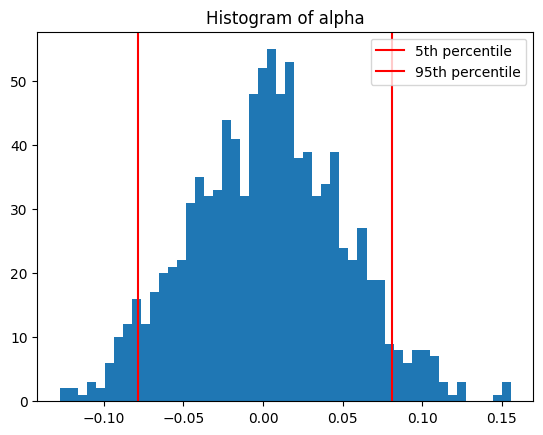

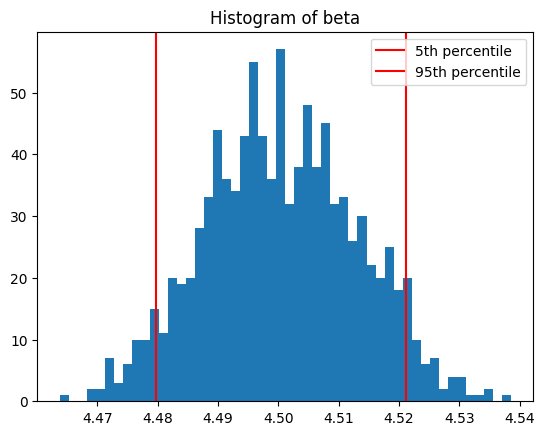

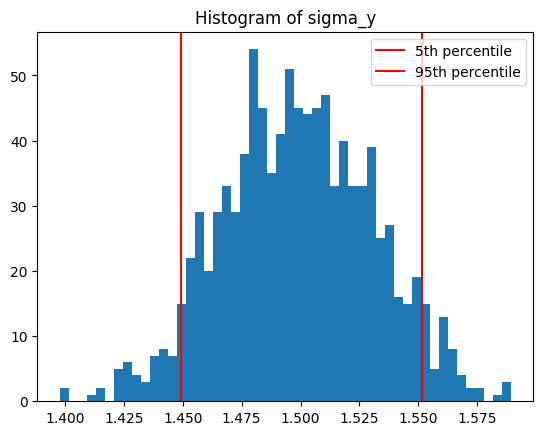

In [191]:
p_alpha = [percentile(alpha_hats, 0.05), percentile(alpha_hats, 0.95)]
p_beta = [percentile(beta_hats, 0.05), percentile(beta_hats, 0.95)]
p_sigma_y = [percentile(sigma_y_hats, 0.05), percentile(sigma_y_hats, 0.95)]

plt.hist(alpha_hats, bins=50)
plt.axvline(p_alpha[0], color='red', label='5th percentile')
plt.axvline(p_alpha[1], color='red', label='95th percentile')
plt.title('Histogram of alpha')
plt.legend()
plt.show()

plt.hist(beta_hats, bins=50)
plt.axvline(p_beta[0], color='red', label='5th percentile')
plt.axvline(p_beta[1], color='red', label='95th percentile')
plt.title('Histogram of beta')
plt.legend()
plt.show()

plt.hist(sigma_y_hats, bins=50)
plt.axvline(p_sigma_y[0], color='red', label='5th percentile')
plt.axvline(p_sigma_y[1], color='red', label='95th percentile')
plt.title('Histogram of sigma_y')
plt.legend()
plt.show()

As seen in the plot of beta the 95% CI lies outside of 0 meaning beta can't be 0

### 1.9
Now repeat this hypothesis test but for the case of only n = 4. Explain briefly the difference between
these two hypothesis tests and why it makes intuitive sense.

[4 points]

In [ ]:
# YOUR CODE HERE
# YOUR CODE HERE
n = 4
s_mean = np.mean(s)
s_std = np.std(s)
s_4 = [[randpair(s_mean, s_std, alpha, beta, sigma_y_x) for _ in range(n)] for _ in range(10**3)]
alpha_hats_4, beta_hats_4, sigma_y_hats_4 = [], [], []

i=1
for sample in s_4:
    alpha_hat_4, beta_hat_4, sigma_y_hat_4 = failsafe_fit_lrm(sample)
    alpha_hats_4.append(alpha_hat_4)
    beta_hats_4.append(beta_hat_4)
    sigma_y_hats_4.append(sigma_y_hat_4)

    if i % 100 == 0:
        print(f'{i} samples fitted')
    i += 1

100 samples fitted
200 samples fitted
300 samples fitted
400 samples fitted
500 samples fitted
600 samples fitted
700 samples fitted
800 samples fitted
900 samples fitted
1000 samples fitted


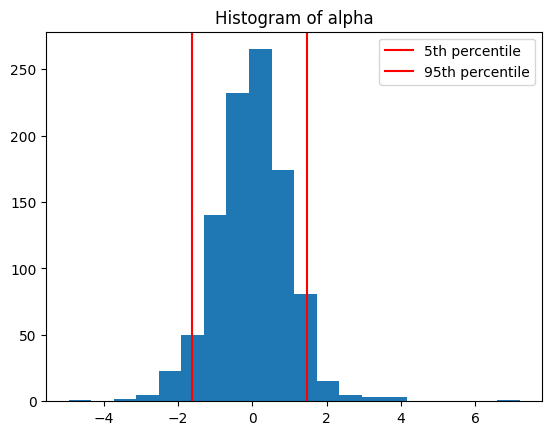

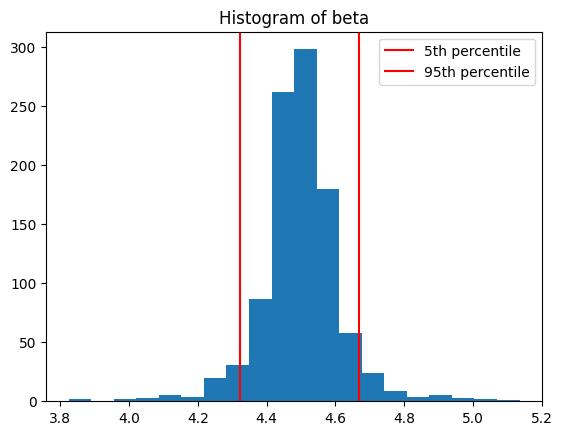

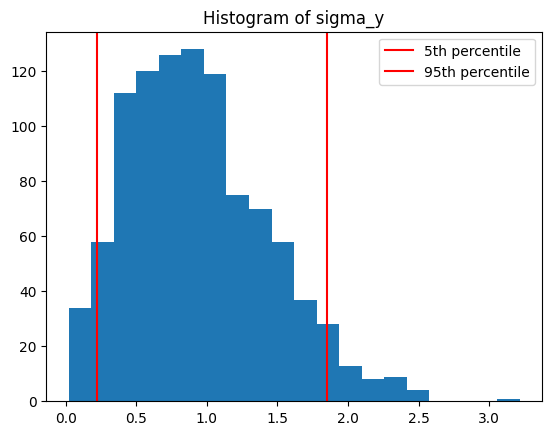

In [193]:
p_alpha_4 = [percentile(alpha_hats_4, 0.05), percentile(alpha_hats_4, 0.95)]
p_beta_4 = [percentile(beta_hats_4, 0.05), percentile(beta_hats_4, 0.95)]
p_sigma_y_4 = [percentile(sigma_y_hats_4, 0.05), percentile(sigma_y_hats_4, 0.95)]

plt.hist(alpha_hats_4, bins=20)
plt.axvline(p_alpha_4[0], color='red', label='5th percentile')
plt.axvline(p_alpha_4[1], color='red', label='95th percentile')
plt.title('Histogram of alpha')
plt.legend()
plt.show()

plt.hist(beta_hats_4, bins=20)
plt.axvline(p_beta_4[0], color='red', label='5th percentile')
plt.axvline(p_beta_4[1], color='red', label='95th percentile')
plt.title('Histogram of beta')
plt.legend()
plt.show()

plt.hist(sigma_y_hats_4, bins=20)
plt.axvline(p_sigma_y_4[0], color='red', label='5th percentile')
plt.axvline(p_sigma_y_4[1], color='red', label='95th percentile')
plt.title('Histogram of sigma_y')
plt.legend()
plt.show()

No big changes

### 1.10

Implement a non-parametric bootstrap procedure to estimate the expected value and CI of each parameter as well, in a separate function such as bootstrap lrm(sample). Use a sufficient number of resamples. Show that the CIs of this method correspond fairly well with those of question 8 and
question 9.

[6 points]

In [163]:
# YOUR CODE HERE

### 1.11

The question whether the slope could be zero was not an arbitrary one (question 8 and question 9). A non-zero slope indicates a statistical relationship between the two variables. This means that if the
slope is non-zero then knowing a value of $x_i$ means that we can better predict the corresponding value of $y_i$ compared to the case where we do not know $x_i$ . Explain briefly in your own words why a slope of zero means that there cannot be any improved prediction from knowing $x_i$.

[3 points]

YOUR ANSWER HERE

### 1.12

An LRM is very closely related to the classical (linear) correlation coefficient, which we will get to in a moment. The most well-known measure to quantify the goodness-of-fit of a model (in our case, an LRM) is the percent of variance ‘explained’ or percent of variance reduction.<sup>3</sup>

Using $\vec s$ , first compute the variance of $Y_i$ and then compute the variance of the so-called residuals
$Y_i − (\alpha + \beta \cdot X_i )$ of the LRM you fitted to this dataset. Compute the percent of variance reduction
obtained by knowing the value of $X_i$ versus not knowing it. This quantity should be higher than 50%. Report the two variances and the percent reduction.

<span style="font-family:Arial; font-size: 0.8em;">Note 3: I like the explanation of http://www.sportsci.org/resource/stats/linreg.html and further pages, such as the
‘goodness-of-fit’ page.</span>

[3 points]

In [164]:
# YOUR ANSWER HERE

### 1.13

Suppose that for some reason we use a very wrong LRM model by taking the negative value for $\hat \beta$. Using ‘wrong’ models happens more often than you think, for instance by fitting a model to one phenomenon (weather in USA) and then trying to apply it to a very different phenomenon (weather in Europe). Or creating a model for the innate immune response in human tissue in the first 36 hours and then trying to predict something after 48 hours or more.

For this ‘wrong’ model again compute the goodness-of-fit. Explain in words why the obtained value makes sense.

[5 points]

YOUR ANSWER HERE

### 1.14
Explain briefly why an increasing value for the slope β for the generating model does not imply an
increasing goodness-of-fit. Which parameter of the LRM is more directly controlling the goodness-of-
fit?

[3 points]

YOUR ANSWER HERE

### 1.15

The most well-known and classical correlation coefficient for cross-sectional samples is the Pearson
product-moment coefficient $−1 ≤ r ≤ 1$.<sup>4</sup> It is strongly related to the LRM.
Calculate $r$ for your dataset $\vec s$ . It is common knowledge that $r^2$ produces the goodness-of-fit of this
correlation function (which we will not derive mathematically here). Compare $r^2$ with your answer to question 12.
Still, we usually report $r$ in statistical studies and not r^2 . Name one clear advantage of this.

<span style="font-family:Arial; font-size: 0.8em;">Note 4: See,
e.g., https://www.wikiwand.com/en/Correlation_and_dependence.</span>

[6 points]

In [165]:
# YOUR CODE HERE

YOUR ANSWER HERE

### 1.16

Three questions. What should be the value of $r^2$ (i.e., percent of variance reduction) if it is true that $σ_{Y|X} = {σ_Y}$ , where $σ_Y$ is the standard deviation of $Y$ , and $β = 0$? What should be the value of $r^2$
when $σ_{Y|X} = 0$ and $β \neq 0$ (and then regenerate the dataset)? What would happen to $r^2$ if you would increase $σ_{Y |X}$ while keeping the $β \neq 0$ constant?

[6 points]

YOUR ANSWER HERE

# Problem 2

In the previous problem you still considered cross-sectional samples of i.i.d. paired values. In this problem
you will transition to time-series. A time-series is a sequence of observations where each observation depends
on (has a statistical relation with) the previous observation(s). This is a transition that we are doing carefully
because there are some caveats. Cross-sectional techniques should not be blindly applied to time-series, as
you will see.

## 2.1

It is very easy to generate your own time-series. First generate a cross-sectional sample $\vec d$ consisting of
$n = 10^2$ i.i.d. values drawn from $\mathcal N (μ = 3, σ = 6)$. Then create the time-series $\vec s_t$ by computing the running sum, i.e., $\vec s_t = \sum_{i=0}^t \vec d_i$ . Show the plot of $\vec s_t$ versus $t$. As an aside, this time-series is now called a *[first-order integrated](https://www.wikiwand.com/en/Order_of_integration)* time-series because it consists of one integration step of a so-called *stationary process* (in our case: i.i.d. values).

[4 points]

In [166]:
# YOUR CODE HERE

### 2.2

The previous problem gives insights into analyzing this time-series. To see this, plot the scatter plot of $n − 1$ points $(\vec s_{t−1} , \vec s_t)$.

[3 points]

In [167]:
# YOUR CODE HERE

### 2.3

Fit an LRM to this time-series using your implemented function. Use $x_t = t$ to make the list of
paired values that your optimization function expects. Why is it incorrect to fit statistical parameters
describing $X_i$ in this case, in contrast to the previous problem?

Report the three fitted parameter values of the LRM. Which values for the intercept and slope should
theoretically be expected?

[4 points]

In [168]:
# YOUR CODE HERE

YOUR ANSWER HERE

### 2.4

You may already have noticed one deviation from the cross-sectional case here: the fitted $σ_{Y|X}$ parameter. It tends to be significantly and structurally larger than the standard deviation of the i.i.d. sample
we started with (which is $σ$). In fact, we should ignore this fitted parameter value; more accuracutely,
this fitted parameter does not estimate $\sigma$. This can be seen, e.g., when drawing the LRM line on
top of the time-series and looking closely at the behavior of the deviations (residuals) from this line.
Explain briefly which assumption is violated in the optimization procedure to estimate $σ$.

[3 points]

YOUR ANSWER HERE

### 2.5

Briefly describe a procedure to correctly estimate $σ$. Estimate its numerical value in this way. 

**Fail-safe:**
simply use the theoretical value used to generate the time-series.

[3 points]

YOUR ANSWER HERE

In [169]:
# YOUR CODE HERE

### 2.6

Using your fitted LRM to generate a single prediction curve of how $\vec s_t$  could continue for the next $n$
time steps. Attach this time-series prediction to $\vec s_t$ and plot it in a different color.

[3 points]

In [170]:
# YOUR CODE HERE

### 2.7 

Of course this is just one prediction out of very many that you could have made with this LRM. Often we want to know the range of predictions that could be made. Therefore, compute 1000 such predictions using your fitted LRM and plot them all using the same transparent color<sup>7</sup> .

Of these 1000 predictions, compute the mean and the CI per time point. Show these three curves in opaque color on top of the same plot. Explain briefly why the CI range widens and why that should
be expected.

<span style="font-family:Arial; font-size: 0.8em;">Note 5: Transparency (90%), a color (blue), and a linewidth (1) can be set using `plt.plot(x, y, ’-’, alpha=0.1, color=(0.0,0.0,1.0), linewidth=1)`.</span>

[6 points]

In [171]:
# YOUR CODE HERE

YOUR ANSWER HERE

### 2.8

The stochasticity of a single prediction model (here LRM) is not the only source of prediction uncertainty. Estimate the mean and standard deviation (so not CI) of each parameter of the LRM (see also
problem 8 in previous question for inspiration) and report the numerical values. Let us assume that
each parameter’s distribution is a normal distribution.

Generate 25 parameter estimates for each parameter. Compute 1000 predictions for each of the 25 parameter sets. Overlay the 25 prediction uncertainties (i.e., the 1000 curves) in optionally different colors
per parameter set onto the same plot. Estimate and show again the mean and CI curves but now of
all the 25000 predictions taken together. Explain the difference of the CI with that of the previous
question.

[5 points]

In [172]:
# YOUR CODE HERE

YOUR ANSWER HERE

### 2.9

Actually, there is yet another source of uncertainty. You have so far fitted an LRM using the entire time-series $\vec s_t$. Sometimes this is not appropriate. Think of weather predictions for example. The temperature of the past few days is more pertinent to tomorrow’s temperature than that of a few
months ago. At a different level, think of the average temperature over a year. This should be a smooth cyclic behavior through the seasons. On the scale of a month or two we can use approximately
an LRM to roughly estimate next month’s temperature, but fitting an entire year should result in slope
0 (unless we’re headed towards the next snowball earth phase). Therefore it may pay off to study the
short-term trends, meaning that only the last $n'$ points are used for regression instead of all $n$.

Describe briefly in words how you could study the added uncertainty from the choice of $n'$.

[3 points]

YOUR ANSWER HERE

## Problem 3

**Bonus problem.** A common task is to find correlations between time-series, such as between global
temperature and local sea level, or between two financial indices. But a very common mistake is made due
to spurious regression, including by myself, which therefore I feel obligated to teach you the idea behind it.
There is a lot more to say about it than handled here, but I hope the basic idea comes across.
The following are some very basic (and perhaps too basic) intuitive descriptions of important and relevant
terms in this context. I strongly suggest you further research a little bit yourself into these terms.

* *Stationary time-series* (in the ‘weak’ sense). There is no ‘trend’ in the time-series: if you would estimate the mean and variance of a certain range of the time series (say, 10% width), then the two values would not have a trend as you slide this range across the time-series (called a sliding window ). That is, there would be some fluctuation of the two estimated values but an LRM should give slope approximately zero (think back of your hypothesis test in Problem 1). A list of i.i.d. samples is always stationary.
* Order of integration. A time-series is first-order integrated if taking the differences $\vec s_t − \vec s_{t−1}$ is a stationary process. A stationary process is considered integrated of order zero. A time-series is $x$-order integrated if taking the differences leads to a $(x − 1)$-order integrated time-series. We will not consider $x > 1$ here.
* Spurious regression or spurious correlation. Finding a significantly non-zero slope $\hat \beta$, or significantly non-zero correlation coefficient (such as r) or goodness-of-fit $r^2$ between two time-series which are actually expected to be uncorrelated. Typically this is due to a common trend, which typically is due to both time-series being first-order integrated (or higher). In turn, this is often because the (non-stationary) time-series are only a small piece of a larger stationary time-series.

### 3.1
Generate an i.i.d. sample $\vec d$ of $n ≥ 100$ samples using any distribution of your choice for each value to be drawn
from. Then generate a second i.i.d. sample $\vec e$ using any (potentially different) distribution. Calculate
the Pearson correlation coefficient r and the percent of variance reduction $r^2$ from these two samples.
Next, do a suitable hypothesis test (parametric or non-parametric) to see if $r^2$ = 0 is a plausible value or not.

[7 bonus points]

In [173]:
# YOUR CODE HERE

### 3.2

Implement your own test of ‘stationarity’ in a function `is_nonstationary(timeseries, p threshold=0.05)`,
where the `timeseries` argument is a single list of scalar values. Do this in a suitable way using LRM
fitting and a hypothesis test using the `p-value` (so not using the CI as done so far), either parametrically or non-parametrically. It is sufficient to reject the hypothesis of zero slope for the time-series
to conclude that the time-series is non-stationary (since there is a trend); you may ignore the variance
condition and no use of a sliding window is needed. Let your function return `(True, p value)` if
the hypothesis can be rejected, where p value is the numerical p-value of the zero slope; otherwise
return (False, p value).<sup>7</sup> Show that the two generated i.i.d. samples are indeed stationary using
your function. Also show that `is_nonstationary(range(100), p threshold=0.05)` returns
`(True, 0.0)`.

<span style="font-family:Arial; font-size: 0.8em;">Note 7: **Warning**: As you well know by now, not being able to reject hypothesis H does not imply that H is true! So you should consider the return value of your function as answering the question: ‘Is the hypothesis of zero slope rejected?’. Not as ‘Is the
time-series non-stationary?’. In our case the two statements are the same but more in general we could have more complicated time dependence relationships, like $X(t)=cos(t)$, which may not be well captured supposing a linear relation</span>

[9 bonus points]

In [174]:
def is_nonstationary(timeseries, p_threshold=0.05):
    # YOUR CODE HERE
    pass

In [175]:
# YOUR CODE HERE

### 3.3

Use $\vec d$ and $\vec e$ to construct first-order integrated time-series $\vec s_t$ and $\vec u_t$ . Show that there is a spurious
regression (slope of LRM) between the two time-series and that the goodness-of-fit (percent of variance
explained) is spurious. Also show that the Pearson correlation coefficient formula returns a spurious
correlation value.

[5 bonus points]

In [176]:
# YOUR CODE HERE

### 3.4

The slope of the LRM between the two time-series which you found in the previous question is usually
denoted $β$ in the literature. It is called the *co-integration factor* of the two time-series. If $β \neq 0$
then the two time-series are said to be `co-integrated` and then spurious regression and spurious
correlation will take place. (As an aside, the converse is not necessarily true.) So the presence of
co-integration acts as a warning sign.

Another common definition is as follows. Two time-series are said to be co-integrated if a linear
combination of the two time-series has a lower order of integration than the two time-series themselves.
Show that such a linear combination exists and that this ‘combined’ time-series indeed has a lower
order of integration.

[6 bonus points]

In [177]:
# YOUR CODE HERE

YOUR ANSWER HERE

### 3.5

Describe a general procedure by which the correlation and/or percent of variance reduction (goodness-
of-fit) should be computed between two time-series. The time-series may be either stationary or
integrated. In your explanation, also briefly mention a mathematical argument in words why the
percent of variance reduction (as computed by the LRM procedure using the two original time-series)
is only valid when the two time-series are stationary, or better yet, i.i.d

[10 bonus points]

YOUR ANSWER HERE

## Problem 4

**Bonus problem** . On Canvas there is a real dataset uploaded containing the amount of particulate matter
(PM) measured by different stations across the Netherlands over time, for a single year computed by averaging
over ten years. Different time-series could be extracted from this dataset, such as per weather station, per
day, per week, weekly averages over time, per season, etc. Experiment with plotting such different views of
the data for yourself.

Search for two time-series in this dataset which are co-integrated and thus having a spurious correlation.
Estimate this ‘spurious’ correlation value and/or goodness-of-fit and then estimate the ‘true’ correlation
value $r$ and/or the goodness-of-fit $r^2$ , using either your LRM procedure (percent of variance reduction) or
the Pearson formula. Make your conclusions statistically sound, i.e., use hypothesis tests to conclude with
confidence that there is co-integration, and the same for testing stationarity. Show the time-series before and
after your transformation(s) and briefly explain whether *a priori* you expected a large or a low correlation.

Note: it is also permitted to find a case where the two time-series are integrated but where the correlation is actually not spurious.

[15 bonus points]

In [178]:
# YOUR CODE HERE

YOUR ANSWER HERE